# 血液細胞の検出

ここでは血液細胞の検出タスクに取り組みます。人の血液の顕微鏡画像が与えられたときに、赤血球（Red Blood Cell; RBC）・白血球（White Blood Cell; WBC）・血小板（Platelet）の3種の細胞をそれぞれ**どの位置にあるか**個別に認識します。これによって、画像内にそれらの細胞が何個づつあるか、ということが分かります。

具体的には、Computer visionという研究領域において、**物体検出（object detection）**と呼ばれているタスクに取り組みます。これは、物体の**種類（クラス）と位置**を画像中から特定するタスクのことを言い、一般的に画像が与えられた際にその画像中に含まれる物体ごとにbounding box（物体を囲む矩形）とクラスの予測値を出力することを指します。物体検出というタスクを考える際は、**画像中にいくつの物体が含まれるかは事前に分からない**ため、任意個（または十分な数）の物体についてbounding boxとクラスの予測値の組を出力できるような手法である必要があります。bounding boxは、（矩形の左上のy座標, 矩形の左上のx座標, 矩形の右下のy座標, 矩形の右下のx座標）のような形式のタプルで定義されることが多く、クラスは物体の種類ごとに振られたIDで表されることが多いようです。

今回は近年、物体検出によく用いられるSingle Shot Multibox Detector（通称SSD）というモデルを、血液細胞の検出に用いてみましょう。

## 準備

まず環境構築のため以下のセルを実行してChainer, CuPy, ChainerCV, matplotlibといったPythonパッケージのインストールを済ませます。

In [1]:
# !curl https://colab.chainer.org/install | sh -
# !pip install chainercv matplotlib

環境のセットアップが成功したことを以下のセルを実行して確認しましょう。

In [2]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.4.0-116-generic-x86_64-with-debian-stretch-sid
Chainer: 5.0.0rc1
NumPy: 1.15.1
CuPy:
  CuPy Version          : 5.0.0rc1
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213


## データセットの準備

### データセットダウンロード

今回は[BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset)という血液の顕微鏡画像と、画像それぞれに対してRBC, WBC, Plateletの3つの物体に対するbounding boxのアノテーションが用意された小規模なデータセットを用います。このデータセットはGithubリポジトリで配布されていますので、以下のセルを実行してデータセットをダウンロードしましょう。

In [3]:
%%bash
if [ ! -d BCCD_Dataset ]; then
    git clone https://github.com/Shenggan/BCCD_Dataset.git
fi

データセットは以下のうようなファイル構成で配布されています。

```
 BCCD
 |-- Annotations
 |   |
 |   `-- BloodImage_00XYZ.xml (364 items)
 |
 |-- ImageSets
 |   |
 |   `-- Main
 |       |
 |       |-- test.txt
 |       |-- train.txt
 |       |-- trainval.txt
 |       `-- val.txt
 |
 `-- JPEGImages
   |
    `-- BloodImage_00XYZ.jpg (364 items)
 ```

他にもディレクトリがありますが、今回用いるのは上記のファイルだけですので、こちらのみに着目しましょう。

- **Annotationsディレクトリ：**VOC formatと呼ばれる形式で細胞画像それぞれに対して**どの位置に何があるか**という、一般的に画像からの物体検出タスクで必要となるラベルの情報が格納されています。
- **ImageSetsディレクトリ：**学習用データセット・検証用データセット・テスト用データセットのそれぞれに用いる画像のリストが記されたテキストファイルが入っています。これを使ってデータセットの分割を行います。
- **JPEGImagesディレクトリ：**実際に学習や検証・テストに用いる画像データが入っています。

### データセットオブジェクト作成

ChainerCVにはPascal VOCデータセットを簡単に読み込むための便利なクラスが用意されています。これを継承し、`_get_annotations`メソッドをオーバーライドして今回使用するデータセットに合わせて変更を加えます。変更が必要な行は１行だけです。[こちら](https://github.com/chainer/chainercv/blob/v0.10.0/chainercv/datasets/voc/voc_bbox_dataset.py#L90-L115)から該当するコードをコピーしてきて、以下の変更を行い、`BCCDDataset`クラスを定義してみましょう。

```
- label.append(voc_utils.voc_bbox_label_names.index(name))
+ label.append(bccd_labels.index(name))
```

In [4]:
import os
import xml.etree.ElementTree as ET

import numpy as np

from chainercv.datasets import VOCBboxDataset


bccd_labels = ('rbc', 'wbc', 'platelets')


class BCCDDataset(VOCBboxDataset):

    def _get_annotations(self, i):
        id_ = self.ids[i]
        anno = ET.parse(
            os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))
        bbox = []
        label = []
        difficult = []
        for obj in anno.findall('object'):
            # when in not using difficult split, and the object is
            # difficult, skipt it.
            if not self.use_difficult and int(obj.find('difficult').text) == 1:
                continue

            difficult.append(int(obj.find('difficult').text))
            bndbox_anno = obj.find('bndbox')
            # subtract 1 to make pixel indexes 0-based
            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(bccd_labels.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)
        # When `use_difficult==False`, all elements in `difficult` are False.
        difficult = np.array(difficult, dtype=np.bool)
        return bbox, label, difficult

これで、今回用いるデータセットクラスを定義することができました。では、これを用いて学習・検証・テスト用のデータセットオブジェクトを作成してみましょう。

In [5]:
train_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'train')
valid_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'val')
test_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'test')

/home/shunta/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/chainercv/datasets/voc/voc_bbox_dataset.py:63: UserWarning: please pick split from 'train', 'trainval', 'val'for 2012 dataset. For 2007 dataset, you can pick 'test' in addition to the above mentioned splits.
  'please pick split from \'train\', \'trainval\', \'val\''


ではデータを可視化して確認してみましょう。trainデータセットから一つデータと対応するラベル情報（bounding boxとクラスの組）を取り出し、ChainerCVが用意している可視化用の便利な関数を使って、画像の上にbounding boxおよび対応するクラスラベルを表示してみます。

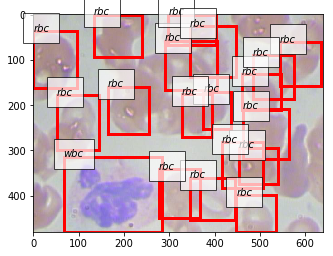

In [6]:
%matplotlib inline
from chainercv.visualizations import vis_bbox

img, bbox, label = train_dataset[0]
vis_bbox(img, bbox, label, label_names=bccd_labels)

## Single Shot Multibox Detector (SSD)

データの準備が完了したので、今回訓練するモデルについて説明を行います。今回は、[Single Shot MultiBox Detector (SSD)](https://arxiv.org/abs/1512.02325)というモデルを使ってみます。

SSDは、single stageタイプと呼ばれる物体検出手法の一種で、[YOLO](https://arxiv.org/abs/1506.02640)などもその一種とされます。これに対し、two stageタイプと呼ばれる手法としては[Faster R-CNN](https://arxiv.org/abs/1506.01497)が有名です。

これらは共通して、まずVGGやResNetのような画像分類で大きな成果をあげたネットワーク構造を用いて画像から特徴マップを抽出します。そのあと、single stageタイプのもの、例えばSSDでは、予め特徴マップの空間方向にびっしりと候補領域を仮定しておき（default boxと呼ばれます）、そのそれぞれについて「どの程度正解のbounding boxからずれているか」を計算し、これを最小化するように学習を行います。また、この位置の補正と同時にそれぞれが「どのクラスに属しているか」も予測させ、この間違いも少なくするよう学習を行います。

一方、two stageタイプの手法、例えばFaster R-CNNでは、抽出された特徴マップに対してさらに別のネットワークが物体の候補領域（region proposal）を予測し、その結果を使って候補領域ごとの特徴ベクトルを作成し（RoI poolingと呼ばれる計算が用いられます）、それらをクラス分類問題と候補領域の修正量を求める回帰問題を解くための2つの異なる小さなネットワークにさらに渡す、という構造をとります。

このため、一般にsingle stageタイプのネットワークの方が高速であると言われます。一方、two stageタイプのものの方が精度は高い、と言われます。このようなトレードオフについては、これを調査した論文（[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)）より、以下の図がしばしば参照されます。
![](images/speed-accuracy-tradeoffs.png)

今回用いるSSDという手法のネットワークアーキテクチャは、SSD論文のFig. 2より以下のような形をしています。

![](images/ssd-architecture.png)

特徴抽出を行うVGG-16ネットワークの途中の出力に対してそれぞれ別々の畳み込み層を適用して検出結果（bounding boxの位置と、その中の物体のクラス）を出力していくことで、複数のスケールでの予測を起こっているのが特徴です。

## モデルの定義

SSDのネットワーク部分の実装は、ChainerCVが提供してくれています。

学習に必要なロス関数を計算するクラスを用意しましょう。

以下に定義するクラスは、まずSSDモデルのオブジェクトと、ロス計算のためのハイパーパラメータである `alpha` と `k` をコンストラクタで受け取っています。`alpha` は、位置の予測に対する誤差とクラスの予測に対する誤差それぞれの間の重み付けを行う係数です。`k` は hard negative mining のためのパラメータです。学習時、一つの正解bounding boxに対して、モデルは一つの近しい（positiveな）予測と、多くの間違った（negativeな）予測を出力します。この多くの間違った予測をconfidence score（モデルがどの程度確信を持ってその予測を出力しているかを表す値）によってソートした上で、上から positive : negative が 1:k になるように negative サンプルを選択し、ロスの計算に使用します。このバランスを決めているのが `k` というパラメータで、上記論文中では $k = 3$ とされているため、ここでもデフォルトで3を使っています。

`forward` メソッドでは、入力画像と正解の位置・ラベルのリストを受け取って、実際にロスの計算を行っています。物体検出は、物体のlocalization（位置の予測）とclassification（種類（＝クラス）の予測）の二つの問題を同時に解きます。SSDでは、localization lossとclassification lossを別々に計算します。

In [7]:
import chainer

from chainercv.links.model.ssd import multibox_loss


class MultiboxTrainChain(chainer.Chain):

    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def forward(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss
    

In [8]:
import copy

import numpy as np

from chainercv import transforms
from chainercv.links.model.ssd import random_crop_with_bbox_constraints
from chainercv.links.model.ssd import random_distort
from chainercv.links.model.ssd import resize_with_random_interpolation


class Transform(object):

    def __init__(self, coder, size, mean):
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        # There are five data augmentation steps
        # 1. Color augmentation
        # 2. Random expansion
        # 3. Random cropping
        # 4. Resizing with random interpolation
        # 5. Random horizontal flipping

        img, bbox, label = in_data

        # 1. Color augmentation
        img = random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(
                img, fill=self.mean, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # 3. Random cropping
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]

        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = resize_with_random_interpolation(img, (self.size, self.size))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

In [ ]:
from chainer.datasets import TransformDataset
from chainer.optimizer_hooks import WeightDecay
from chainer import serializers
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainercv.links import SSD300
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links.model.ssd import GradientScaling


batchsize = 32
gpu_id = 0
out = 'results'

model = SSD300(n_fg_class=len(bccd_labels), pretrained_model='imagenet')
model.nms_thresh = 0.5
model.score_thresh = 0.6
train_chain = MultiboxTrainChain(model)

transformed_train_dataset = TransformDataset(train_dataset, Transform(model.coder, model.insize, model.mean))

train_iter = chainer.iterators.MultiprocessIterator(transformed_train_dataset, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid_dataset, batchsize, repeat=False, shuffle=False)

optimizer = chainer.optimizers.MomentumSGD(lr=0.001)
optimizer.setup(train_chain)
for param in train_chain.params():
    if param.name == 'b':
        param.update_rule.add_hook(GradientScaling(2))
    else:
        param.update_rule.add_hook(WeightDecay(0.0005))

updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (100, 'epoch'), out)
# trainer.extend(
#     extensions.ExponentialShift('lr', 0.1, init=1e-3),
#     trigger=triggers.ManualScheduleTrigger([20, 25], 'epoch'))

trainer.extend(
    DetectionVOCEvaluator(
        valid_iter, model, use_07_metric=False,
        label_names=bccd_labels),
    trigger=(1, 'epoch'))

log_interval = 1, 'epoch'
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'lr',
     'main/loss', 'main/loss/loc', 'main/loss/conf',
     'validation/main/map', 'elapsed_time']),
    trigger=log_interval)
# trainer.extend(extensions.ProgressBar(update_interval=10))
trainer.extend(extensions.snapshot(), trigger=(10, 'epoch'))

trainer.run()

From: https://chainercv-models.preferred.jp/ssd_vgg16_imagenet_converted_2017_06_09.npz
To: /home/shunta/.chainer/dataset/_dl_cache/b4130ae0aa259c095b50ff95d81c32ee
  %   Total    Recv       Speed  Time left
100   76MiB   76MiB   4276KiB/s    0:00:00epoch       iteration   lr          main/loss   main/loss/loc  main/loss/conf  validation/main/map  elapsed_time
1           7           0.001       10.9707     3.00224        7.96849         0.0722822            73.0088       
2           13          0.001       8.75201     2.65343        6.09858         0.0193504            118.349       
3           20          0.001       10.3778     2.43065        7.94711         0.14623              158.022       
4           26          0.001       8.52394     2.43299        6.09096         0.0678337            192.32        
5           33          0.001       7.22973     2.17006        5.05966         0.116555             227.334       
6           39          0.001       9.29358     2.47002       